In [73]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(G):
    plt.figure(figsize=(10, 8))


    # Plot the graph nodes
    node_pos = {i: (G.nodes[i]['o'][1], G.nodes[i]['o'][0]) for i in G.nodes()}
    nx.draw_networkx_nodes(G, pos=node_pos, node_size=20, node_color='red')

    # Plot the graph edges
    for (s, e) in G.edges():
        ps = G[s][e]['pts']
        plt.plot(ps[:, 1], ps[:, 0], 'green')
    plt.title('Skeleton Graph Visualization')
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_binary_image(image):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.show()

def plot_centerline(centerline, xy):
    plt.figure(figsize=(10, 8))
    plt.plot(centerline[:, 0], centerline[:, 1], 'b-', linewidth=2, label='Centerline')
    plt.scatter(xy[:, 0], xy[:, 1], c='r', s=10, alpha=0.5, label='Original Points')
    plt.title('Track Centerline')
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)

    plt.show()

In [66]:
import numpy as np

def asymmetric_widths(track_bin: np.ndarray,
                      centerline: np.ndarray,
                      resolution: float,
                      step_px: float = 0.5) -> tuple[np.ndarray, np.ndarray]:
    """
    Measure asymmetric track half‑widths by ray‑casting along the local normal.

    Parameters
    ----------
    track_bin  : 2‑D bool / uint8   (1 = free space, 0 = wall)
    centerline : (N, 2) float       x‑y points in *metres*
    resolution : float              map resolution [m / pixel]
    step_px    : float              ray‑cast increment in pixels

    Returns
    -------
    w_right, w_left : (N,) float    half‑widths in metres
    """
    track_bin = 1 - track_bin
    h, w = track_bin.shape
    step_m  = step_px * resolution         # metres added per successful step
    n_pts   = len(centerline)
    w_right = np.zeros(n_pts, dtype=np.float32)
    w_left  = np.zeros(n_pts, dtype=np.float32)

    # --- unit tangents & normals ---------------------------------------------
    t = np.empty_like(centerline)
    t[1:-1] = centerline[2:] - centerline[:-2]
    t[0]    = centerline[1]  - centerline[-1]
    t[-1]   = centerline[0]  - centerline[-2]

    t /= np.linalg.norm(t, axis=1, keepdims=True) + 1e-9   # avoid /0
    n_unit = np.stack((-t[:, 1], t[:, 0]), axis=1)         # [-ty, tx]

    # helper to walk a ray -----------------------------------------------------
    def march(pos_rc: np.ndarray, n_rc: np.ndarray) -> float:
        dist = 0.0
        while True:
            pos_rc += n_rc * step_px               # 1. step
            r, c = int(pos_rc[0]), int(pos_rc[1])  # floor, not round
            if r < 0 or r >= h or c < 0 or c >= w: # 2. bounds check
                break
            if not track_bin[r, c]:                # 3. hit a wall
                break
            dist += step_m
        return dist

    # --- main loop ------------------------------------------------------------
    for i, (p_xy, n_xy) in enumerate(zip(centerline, n_unit)):
        rc0 = np.array([p_xy[1], p_xy[0]]) / resolution   # metres → (row,col)
        n_rc = n_xy[::-1]                                 # swap to (row,col)

        w_right[i] = march(rc0.copy(),  n_rc)   # +n
        w_left[i]  = march(rc0.copy(), -n_rc)   # -n

    return w_right, w_left


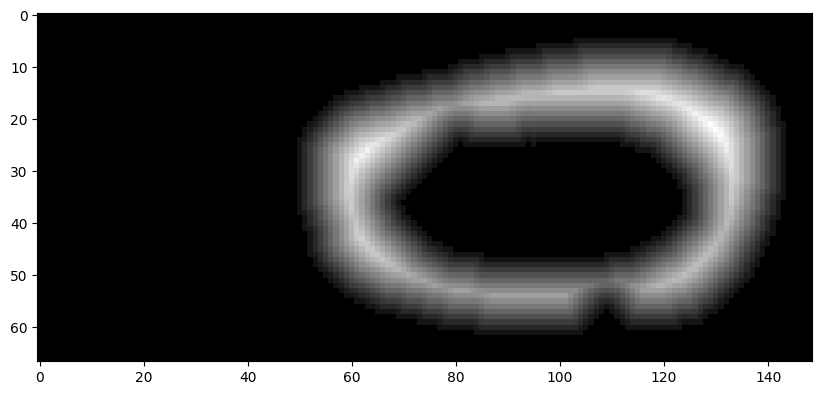

In [75]:
import cv2
from scipy.ndimage import binary_closing, binary_opening
from scipy.ndimage import distance_transform_edt, map_coordinates
from scipy.spatial import cKDTree
from scipy.interpolate import CubicSpline
from skimage.morphology import medial_axis, skeletonize
import networkx as nx
import sknw
import matplotlib.pyplot as plt
import numpy as np

free_space = cv2.imread('/Users/owenburns/workareas/UCF Projects/Senior-Design-Software/darkened_free_space_loop_closed.png')

# Convert the RGB image to grayscale
if len(free_space.shape) == 3:  # Check if it's a color image
    gray_space = cv2.cvtColor(free_space, cv2.COLOR_BGR2GRAY)
else:
    gray_space = free_space  # Already grayscale

# Convert to binary where 255 becomes 1
binary_space = np.zeros((gray_space.shape[0], gray_space.shape[1]), dtype=np.uint8)
binary_space[gray_space > 127] = 1

# eliminate holes and noise
track = binary_opening(binary_space, iterations=2)
track = binary_closing(track, iterations=2)

# get a 1 pixel wide skeleton of the centerline
D = distance_transform_edt(track)
skel = skeletonize(D)

# convert that to a path graph
G = sknw.build_sknw(skel)
path = []
for (s, e) in G.edges():
    path.extend(G[s][e]['pts'])
xy = np.array(path)*0.05

# Smooth the path
seg_len = np.linalg.norm(np.diff(xy, axis=0), axis=1)
s = np.hstack(([0], np.cumsum(seg_len)))
csx = CubicSpline(s, xy[:,0])
csy = CubicSpline(s, xy[:,1])
s_u = np.linspace(0, s[-1], 1000)
centerline = np.c_[csx(s_u), csy(s_u)]

# get the distance on both sides of the centerline
# use the edt thing to get the distance to each wall by masking the inside and outside of the track

# Plot the centerline

